In [1]:
# init settings
import os
import sys
pwd = os.getcwd()
sys.path.append(os.path.join(pwd, '..', '..'))

from server.utils import load_config
from server import db
from sqlalchemy.orm import sessionmaker
import json
import matplotlib.pyplot as plt

conf_dir = os.path.abspath(os.path.join(pwd, '..', '..', 'config', 'base.yaml'))
config = load_config(conf_dir)

engine = db.sync_engine(config['postgres'])
Session = sessionmaker(bind=engine)
session = Session()

In [2]:
# Query data

from sqlalchemy.orm.exc import NoResultFound
import sqlalchemy as sa

rate = False
all_orders = False
start_date_filter = '2017-04-13 00:00'
end_date_filter = '2017-04-15 23:59'
price = 1186.991

pair = 'btc_usd'
cursor = session.query(db.order).filter(
    (db.order.c.extra['is_finished'].astext == '0')
    & (db.order.c.pair == pair)
    & (db.order.c.pub_date > start_date_filter)
    & (db.order.c.pub_date < end_date_filter)
).order_by(db.order.c.pub_date)

if all_orders:
    all_orders = session.query(db.order).filter(
        (db.order.c.pair == pair)
        & (db.order.c.pub_date > start_date_filter)
        & (db.order.c.pub_date < end_date_filter)
    ).order_by(db.order.c.pub_date)

if rate:
    rate = session.query(db.history).filter(
        (db.history.c.pub_date > start_date_filter)
        & (db.history.c.pub_date < end_date_filter)
        & (db.history.c.pair == pair)
        & (sa.sql.func.random() < 0.001)
    ).order_by(db.history.c.pub_date)

def as_dict(row):
    item = row._asdict().copy()
    item['api'] = item['api']
    return item

def iter_tail(item, tail):
    next_steps = session.query(db.order).filter(
        ((db.order.c.extra['next'].astext == str(item['id']))
        #| (db.order.c.extra['merged'].astext == str(item['id']))
        ) 
        & (db.order.c.pub_date > start_date_filter)
        & (db.order.c.pub_date < end_date_filter)
    )
    if not next_steps.count():
        if len(tail) == 0:
            tail.append([item, item])
        return tail
    else: 
        for next_step in next_steps:
            next_step_item = as_dict(next_step)
            #print(item, next_step_item)
            tail.append([item, next_step_item])
            tail = iter_tail(next_step_item, tail)
        return tail

In [17]:
from server.trade.SimpleStrategy import SimpleStrategy

# Data proccesing
order_dict = {
    'sell': [],
    'buy': []
}
if all_orders:
    for order in all_orders:
        order_dict['sell' if order.is_sell else 'buy'].append({
            'date': order.pub_date,
            'price': order.price
        })
if rate:   
    rate_dict = {
        'date': [],
        'sell_price': [],
        'buy_price': []
    }
    for rate_info in rate:
        resp = json.loads(rate_info.resp)
        rate_dict['date'].append(rate_info.pub_date)
        rate_dict['buy_price'].append(resp['asks'][0][0])
        rate_dict['sell_price'].append(resp['bids'][0][0])
    print(len(rate_dict['date']))
    
thread_list = []
calc_real = True

def get_fee(delta):
    return (1 + (delta*(0.2 + 0)/100))

def calc_money(order):
    if order['is_sell']:
        btc_delta = -1
        usd_delta = 1
        fee_delta = -1
    else:
        btc_delta = 1
        usd_delta = -1
        fee_delta = 1
    return {
        'usd': usd_delta * order['amount'] * order['price'] * get_fee(fee_delta),
        'btc': btc_delta * order['amount']
    }

# real data from exchange
plot_info = []
all_btc_summ = 0
all_usd_summ = 0
btc_money_spend = 0
usd_money_spend = 0

#calculated data
model_plot_info = []
model_all_btc_summ = 0
model_all_usd_summ = 0

for index, order in enumerate(cursor):
    #if index in [0,1,2,3]:
    #    continue
    item = as_dict(order)
    tail = []
    tail = iter_tail(item, tail)
    thread_list.append(tail)
    usd_sum = 0
    btc_sum = 0
    print('------ thread items ----')
    for index, (next_order, previous) in enumerate(tail[::-1]):
        if calc_real and not next_order['api']:
            print('invalid API {}'.format(next_order['id']))
            continue
            
        if calc_real and not previous['api']:
            print('invalid API {}'.format(previous['id']))
            continue
            
        if calc_real and (float(previous['api']['received']) < 0.0001):
            print('it is order not deal {} {} {}'.format(
                previous['id'],
                previous['api']['received'],
                previous['pub_date']
            ))
            continue
            
        if calc_real and (float(next_order['api']['received']) < 0.0001):
            print('it is order not deal {} {} {}'.format(
                next_order['id'], 
                next_order['api']['received'],
                next_order['pub_date']
            ))
            continue

        print(
            'previos price {} id {}'.format(previous['price'], previous['id']),
            'sell' if previous['is_sell'] else 'buy',
            'next price {} {}'.format(next_order['price'], next_order['id']),
            'sell' if next_order['is_sell'] else 'buy',
        )
        if previous['is_sell']:
            btc_delta = -1
            usd_delta = 1
            fee_delta = -1
        else:
            btc_delta = 1
            usd_delta = -1
            fee_delta = 1
            
        if calc_real:
            btc_money_spend = float(previous['api']['funds']['btc']) - float(previous['api']['old_balance']['btc'])
            usd_money_spend = float(previous['api']['funds']['usd']) - float(previous['api']['old_balance']['usd'])
            btc_sum += btc_money_spend
            usd_sum += usd_money_spend

            all_usd_summ += usd_money_spend
            all_btc_summ += btc_money_spend
            
        money_change = calc_money(previous)
        
        model_all_usd_summ +=money_change['usd']
        model_all_btc_summ +=money_change['btc']
        
        print ('strategy spend {} usd {} btc'.format(usd_strategy_spend, btc_strategy_spend))
        print('{} {} usd {} btc'.format(len(plot_info), usd_money_spend, btc_money_spend))
        
        if previous['extra'].get('merged'):
            print('merged {} {} usd {} btc'.format(previous['id'], usd_money_spend, btc_money_spend))
            plot_info.append({
                'usd': all_usd_summ,
                'btc': all_btc_summ,
                'date': previous['pub_date']
            })
            model_plot_info.append({
                'usd': model_all_usd_summ,
                'btc': model_all_btc_summ,
                'date': previous['pub_date']
            })
            continue
        if previous['id'] == next_order['id']:
            print('not working thread {} {} usd {} btc'.format(previous['id'], usd_money_spend, btc_money_spend))
            plot_info.append({
                'usd': all_usd_summ,
                'btc': all_btc_summ,
                'date': previous['pub_date']
            })
            model_plot_info.append({
                'usd': model_all_usd_summ,
                'btc': model_all_btc_summ,
                'date': previous['pub_date']
            })
            continue
        
        if index + 1 == len(tail):
            print ('strategy spend {} usd {} btc'.format(usd_strategy_spend, btc_strategy_spend))    
            money_change = calc_money(next_order)
            
            model_all_usd_summ +=money_change['usd']
            model_all_btc_summ +=money_change['btc']
            
            if calc_real:
                btc_money_spend = float(next_order['api']['funds']['btc']) - float(next_order['api']['old_balance']['btc'])
                usd_money_spend = float(next_order['api']['funds']['usd']) - float(next_order['api']['old_balance']['usd'])

                print('last {} {} usd {} btc'.format(next_order['id'], usd_money_spend, btc_money_spend))

                usd_sum += usd_money_spend
                btc_sum += btc_money_spend

                all_usd_summ += usd_money_spend
                all_btc_summ += btc_money_spend
            
            
        plot_info.append({
            'usd': all_usd_summ,
            'btc': all_btc_summ,
            'date': previous['pub_date']
        })
        model_plot_info.append({
            'usd': model_all_usd_summ,
            'btc': model_all_btc_summ,
            'date': previous['pub_date']
        })
        
        
    print('------ thread {} summ ----'.format(index))
    print('{} usd {} btc'.format(usd_sum, btc_sum))
    

    #break
print('Total: {} usd {} btc'.format(all_usd_summ, all_btc_summ))

print('If price {} then sum in usd {}'.format(price, all_usd_summ + (all_btc_summ * price)))

------ thread items ----
previos price 1206.005 id 5604 buy next price 1206.005 5604 buy
strategy spend 1.177378524 usd -0.001 btc
0 -1.2060049999999904 usd 0.0009979999999999989 btc
not working thread 5604 -1.2060049999999904 usd 0.0009979999999999989 btc
------ thread 0 summ ----
-1.2060049999999904 usd 0.0009979999999999989 btc
------ thread items ----
previos price 1200.01 id 5607 buy next price 1200.01 5607 buy
strategy spend 1.177378524 usd -0.001 btc
1 -1.200010000000006 usd 0.0009979999999999989 btc
not working thread 5607 -1.200010000000006 usd 0.0009979999999999989 btc
------ thread 0 summ ----
-1.200010000000006 usd 0.0009979999999999989 btc
------ thread items ----
previos price 1206.003 id 5602 buy next price 1206.004 5603 sell
strategy spend 1.177378524 usd -0.001 btc
2 -1.2060030000000097 usd 0.0009979999999999989 btc
previos price 1206.004 id 5603 sell next price 1198.245 5650 buy
strategy spend 1.177378524 usd -0.001 btc
3 1.2035920000000004 usd -0.0010000000000000009 

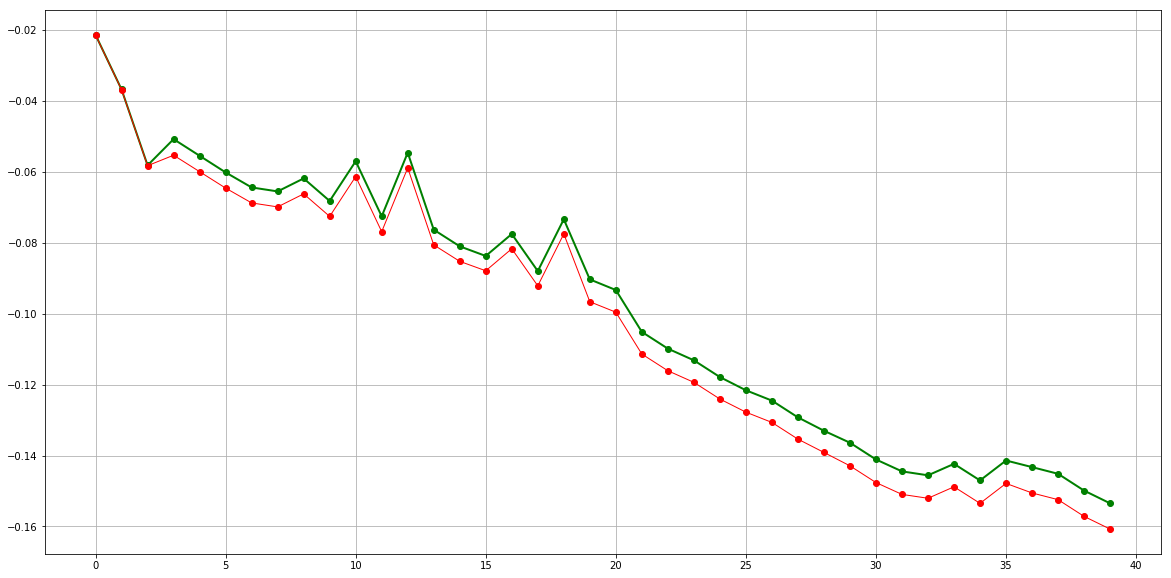

In [18]:
plt.cla()
plt.clf()
fig = plt.figure(figsize=(20,10))

ay = fig.add_subplot(1,1,1)
ay.grid(True)
if calc_real:
    ay.plot(
        list(map(lambda i: i[0], enumerate(plot_info))), 
        list(map(lambda i: i['usd']+i['btc']*price, plot_info)),
        'go-', linewidth=2
    )
ay.plot(
    list(map(lambda i: i[0], enumerate(plot_info))), 
    list(map(lambda i: i['usd']+i['btc']*price, model_plot_info)),
    'ro-', linewidth=1
)
fig

In [ ]:
# Data visualisite

plt.cla()
plt.clf()
fig = plt.figure(figsize=(20,10))

ay = fig.add_subplot(1,1,1)
ay.grid(True)

for name, vals in order_dict.items():
    ay.plot(
        list(map(lambda i: i['date'], vals)), 
        list(map(lambda i: i['price'], vals)),
        color = 'red' if name == 'sell' else 'blue'
    )

if rate:    
    ay.plot(rate_dict['date'], rate_dict['buy_price'], alpha=0.2, color='blue')
    ay.plot(rate_dict['date'], rate_dict['sell_price'], alpha=0.2, color='red')

if all_orders:
    fig

In [ ]:
plt.cla()
plt.clf()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
cm = plt.get_cmap('Vega10')
for index, thread in enumerate(thread_list):
    for line in thread:
        ax.plot(
            list(map(lambda i: i['pub_date'], line)), 
            list(map(lambda i: i['price'], line)),
            color=cm(index)
        )
        
if rate:    
    ax.plot(rate_dict['date'], rate_dict['buy_price'], alpha=0.2, color='blue')
    ax.plot(rate_dict['date'], rate_dict['sell_price'], alpha=0.2, color='red')
    
fig